# IMPORTS

In [ ]:
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Input, Sequential, Model, initializers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta , RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
from tensorflow.keras.backend import abs
import numpy.random as rng
import tensorflow.keras
import cv2
import os
from sklearn.metrics import accuracy_score
import time
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
os.chdir(r'C:\Users\idan\Desktop\ass2\DL_Ass2 - Copy')
cwd = os.getcwd()
cwd

'C:\\Users\\idan\\Desktop\\ass2\\DL_Ass2 - Copy'

# Process images into train, test and validation sets

In [ ]:
def pairsDevReader(path,scale,image_size):
    """
    read images and create dataset contains match and mismatch couples according to LFW dataset
    returns:
    Input: path - string path to dataset
           scale - 0 for grayscale , 1 for colorfull
    Output:
        X - dataset contains images (shape:(2, num_of_samples, image length, image width))
        Y - labels (shape: num_of_samples)
    """
    infile = open(path, 'r')
    firstLine = infile.readline()
    rows_to_read = int(firstLine)
    print('reading first {} rows'.format(rows_to_read))
    match_columns = ["firstname", "firstindex","secondindex"]
    mismatch_columns =["firstname","firstindex","secondname","secondindex"]
    df_match = pd.read_csv(path,skiprows=1,nrows=rows_to_read, sep='\t',header = None)
    df_match.columns = match_columns
    df_mismatch = pd.read_csv(path, skiprows = rows_to_read + 1, nrows=rows_to_read, sep='\t', header = None)
    df_mismatch.columns = mismatch_columns
    X = []
    Y = []
    paper_SNN_input_size = image_size
    # read images of match person
    print('Adding match images')
    for i in range(len(df_match)):
        personName = df_match['firstname'][i]
        firstIndex = df_match['firstindex'][i]
        secondIndex = df_match['secondindex'][i]
        personA_pic1 =  np.float32(cv2.imread(os.path.join(cwd, 'lfw', personName, "{}_{:04d}.jpg".format(personName, firstIndex)) , scale))
        personA_pic1 =  cv2.resize(personA_pic1,image_size)
        personA_pic2 = np.float32(cv2.imread(os.path.join(cwd, 'lfw', personName, "{}_{:04d}.jpg".format(personName, secondIndex)) , scale))
        personA_pic2 =  cv2.resize(personA_pic2, image_size)

        X.append([personA_pic1,personA_pic2])
        Y.append(0)
    # read images of match mismatch people
    print('Adding mismatch images')
    for i in range(len(df_mismatch)):
        firstName = df_mismatch['firstname'][i]
        firstIndex = df_mismatch['firstindex'][i]
        secondName = df_mismatch['secondname'][i]
        secondIndex = df_mismatch['secondindex'][i]
        personA_pic =  np.float32(cv2.imread(os.path.join(cwd, 'lfw', firstName, "{}_{:04d}.jpg".format(firstName, firstIndex)), scale))
        personA_pic =  cv2.resize(personA_pic, image_size)
        personB_pic = np.float32(cv2.imread(os.path.join(cwd, 'lfw', secondName, "{}_{:04d}.jpg".format(secondName, secondIndex)), scale))
        personB_pic = cv2.resize(personB_pic, image_size)

        X.append([personA_pic,personB_pic])
        Y.append(1)

    #shuffle match and mismatch examples:
    X = np.array(X)
    if scale == 0:
        X = X.reshape(X.shape + (1,))
    shuffle_index = np.arange(len(Y))
    np.random.shuffle(shuffle_index)
    Y = np.array(Y)[shuffle_index]
    X = np.array(X)[shuffle_index]
    X = [X.swapaxes(0, 1)[0], np.array(X).swapaxes(0, 1)[1]]
    return X , np.array(Y)

# GENERATE MODEL :
https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

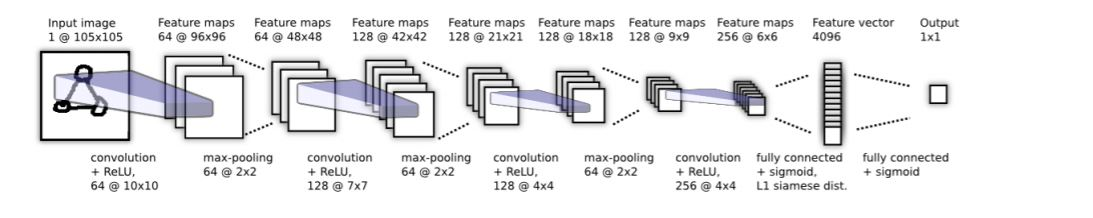

In [ ]:
from IPython.display import Image
Image(filename= os.path.join(cwd, 'net.JPG') )


In [ ]:
def generate_scale_paper_model(input_shape, use_dropout,model_path, path_for_weights, use_batchnorm):
    """
    generates model from paper with optional batchnorma and dropout.
    Input: use_dropout - boolean
           model_path - string, path to already saved model
           path_for_weights - string, path to already saved model
    Output:
    returns an instance of the model, without a distance layer.

    """
    model = Sequential()

    #Since we are using ReLU neurons, we will initialize them with a slightly
    #positive initial bias to avoid "dead neurons"
    # 64 @ 10*10
    init_bias =  initializers.RandomNormal(mean=0.5, stddev=0.01)
    weights_initializer = initializers.RandomNormal(mean=0.0, stddev=0.01)
    kernel_reg = l2(2e-4)
    model.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
                         kernel_regularizer=kernel_reg, kernel_initializer=weights_initializer, bias_initializer=init_bias))

    if use_batchnorm:
        model.add(BatchNormalization())

    #maxpooling 64 @ 2*2
    model.add(MaxPooling2D())
    # 128 @ 7*7
    model.add(Conv2D(128, (7, 7), activation='relu', kernel_regularizer=kernel_reg,
                          kernel_initializer=weights_initializer, bias_initializer=init_bias))

    if use_batchnorm:
        model.add(BatchNormalization())

     #maxpooling 64 @ 2*2
    model.add(MaxPooling2D())
    # 128 @ 4*4
    model.add(Conv2D(128, (4, 4), activation='relu', kernel_regularizer=kernel_reg,
                        kernel_initializer=weights_initializer, bias_initializer=init_bias))

    if use_batchnorm:
        model.add(BatchNormalization())

    #maxpooling 64 @ 2*2
    model.add(MaxPooling2D())
    # 256 @ 4*4
    model.add(Conv2D(256, (4, 4), activation='relu', kernel_regularizer=kernel_reg,
                        kernel_initializer=weights_initializer, bias_initializer=init_bias))
    if use_batchnorm:
        model.add(BatchNormalization())

    if use_dropout:
        model.add(Dropout(rate=0.2))

    #fully connected + sigmoid
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(1e-3),
                   kernel_initializer=weights_initializer, bias_initializer=init_bias))
    return model

def create_siam_network(model,input_shape):
    """
    generates siam network containing two instances of the recived model connected to a distance layer.
    Input: use_dropout - boolean
           model - tensorflow model
           input_shape - shape on the images (e.g. 105,105,1)
    Output:
    returns siam network with L1 distance layer.
    """
    siamA_input = Input(input_shape)
    siamB_input= Input(input_shape)
    siamA_model = model(siamA_input)
    siamB_model = model(siamB_input)
    # L1 distance layer
    distance_lambda = Lambda(lambda t: abs(t[0] - t[1]))
    distance_layer = distance_lambda([siamA_model, siamB_model])
    # output : @ 1 * 1
    output = Dense(1, activation='sigmoid')(distance_layer)
    #Siamese Neural Network:
    SNN = Model([siamA_input, siamB_input], outputs=output)
    print('---------------------------------SNN SHAPE-------------------------------------------')
    print(SNN.summary())
    return SNN


In [ ]:
def save_models_images_samples(results,Y_test,X_test,directory):
    """
    saving examples of model predictions, in order to assess the model results
    Y_test - real labels
    results - model predictions (rounded)
    X_test - images

    """
    print('saving exampled of model right and wrong exampled')
    good_examples_number = 0
    matches = []
    bad_examples_number = 0
    mis_matches = []
    good_images_path = os.path.join(directory,'model_was_right')
    bad_images_path =  os.path.join(directory,'model_failed')
    if not os.path.exists(good_images_path):
        os.makedirs(good_images_path)
    if not os.path.exists(bad_images_path):
        os.makedirs(bad_images_path)
    i = 0
    print('saving good images')
    while good_examples_number < 20:
        if results[i] == Y_test[i]:
            good_examples_number = good_examples_number + 1
            matches.append((X_test[0][i],X_test[1][i]))
        i = i + 1

    print('saving bad images')
    i = 0
    while bad_examples_number < 20:
        if results[i] != Y_test[i]:
            bad_examples_number = bad_examples_number + 1
            mis_matches.append((X_test[0][i],X_test[1][i]))
        i = i + 1

    for touple in range(len(matches)):
        cv2.imwrite(os.path.join(good_images_path, '{}A.png'.format(touple)), matches[touple][0].squeeze())
        cv2.imwrite(os.path.join(good_images_path, '{}B.png'.format(touple)), matches[touple][1].squeeze())

    for touple in range(len(mis_matches)):
        cv2.imwrite(os.path.join(bad_images_path, '{}A.png'.format(touple)), mis_matches[touple][0].squeeze())
        cv2.imwrite(os.path.join(bad_images_path, '{}B.png'.format(touple)), mis_matches[touple][1].squeeze())




# GENERATE EXPERMIENTS

In [ ]:
#generate a dictionary of optional models params

experiments_dict = {'grayscale_paper_model':{'optimizer':[Adam(lr=0.00006),Adagrad(lr = 0.01),RMSprop(lr=0.001)],'loss_func':['binary_crossentropy','mean_squared_error'],'compile_metric':['binary_accuracy'] \
                                      ,'batch_size':[128],'epoch_num':30,'use_dropout':[False,True],'use_batchnorm': [True, False],'patience':3,'set_callback': EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)\
                                      ,'image_size':(105,105),'INPUT_DIM':(105,105,1),'scale':0,'callmodel_func':generate_scale_paper_model,'model_path': '','path_for_weights':'', 'augmentation':[True]}
                   }


In [ ]:
def generate_augmentation(X_train):
    '''
    generated images with augmentation using ImageDataGenrator in order to improve performance and avoid overfitting
    Input: X_train - images to fit the generator
    Output: trained geneator object
    '''
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    print('training augmentation')
    datagen.fit(X_train[0])
    datagen.fit(X_train[1])
    return datagen


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from tensorflow.keras.utils import plot_model

def exper_maker():
    '''
    the main function, generates a siam network and process multple experiments

    '''
    model_num = 0
    # SET MODEL HYPER PARAM #
    for i in experiments_dict:
        directory = os.path.join(cwd, i)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print('CREATED directory at: {}'.format(directory))

        print('SETTING UP {} EXPERIMENT'.format(i))
        optimizers = experiments_dict[i]['optimizer']
        loss_funcs = experiments_dict[i]['loss_func']
        compile_metric = experiments_dict[i]['compile_metric']
        batch_size_options = experiments_dict[i]['batch_size']
        epoch_num = experiments_dict[i]['epoch_num']
        use_dropout_options = experiments_dict[i]['use_dropout']
        use_batchnorm_options = experiments_dict[i]['use_batchnorm']
        #patience: Number of epochs with no improvement after which training will be stopped.
        patience = experiments_dict[i]['patience']
        set_callback =  experiments_dict[i]['set_callback']
        image_size = experiments_dict[i]['image_size']
        INPUT_DIM = experiments_dict[i]['INPUT_DIM']
        MODEL = experiments_dict[i]['callmodel_func']
        model_path = experiments_dict[i]['model_path']
        path_for_weights = experiments_dict[i]['path_for_weights']
        augmentations = experiments_dict[i]['augmentation']
        #CREATE DATA
        #SCALE is 0 for grayscale and 1 for colorful
        scale = experiments_dict[i]['scale']
        try:
            X_train, Y_train = pairsDevReader('pairsDevTrain.txt',scale,image_size)

            #X_train, X_validation, Y_train, Y_validation = create_train_validation_set(X_train,Y_train)

            X_test, Y_test = pairsDevReader('pairsDevTest.txt',scale,image_size)
            X_test = np.array(X_test)
            Y_test = np.array(Y_test)
            X_train = np.array(X_train)
            Y_train = np.array(Y_train)

            X_train = [X_train[0], X_train[1]]
            X_test = [X_test[0], X_test[1]]
            #X_validation = [X_validation[0],X_validation[1]]
            print('X_test shape {}'.format(np.array(X_test).shape))


            #CREATE MODEL
            output_path = os.path.join(cwd, i, 'model - {}.csv'.format(i))
            fields_name = ['optimizer','dropout','batchnorm','batchsize','loss','test accuracy','augmentation','duration']
            with open(output_path, mode='w', newline='') as file:
                writer = csv.DictWriter(file, fieldnames=fields_name)
                writer.writeheader()
            for loss_func in loss_funcs:
                for optimizer in optimizers:
                    optimizer_name = optimizer.get_config()['name']
                    for use_dropout in use_dropout_options:
                        for batch_size in batch_size_options:
                            for use_batchnorm in use_batchnorm_options:
                                for use_augmentation in augmentations:
                                    model_string = 'loss_{}_optim_{}_batchsize_{}_dropout_{}_batchnorm_{}_augmentation_{}'.format(loss_func,optimizer_name,batch_size,use_dropout,use_batchnorm,use_augmentation)
                                    print('model - {}'.format(model_string))
                                    board = TensorBoard(log_dir = os.path.join(cwd,'TensorBoardLogs',i,'{}'.format(model_string)),histogram_freq=1, write_graph = True, write_images = True, update_freq='batch')
                                    my_model = MODEL(INPUT_DIM, use_dropout, model_path, path_for_weights, use_batchnorm)
                                    print("model {}".format(model_num))
                                    model_num += 1
                                    SNN = create_siam_network(my_model, INPUT_DIM)
                                  #COMPILE MODEL
                                    SNN.compile(loss=loss_func, optimizer=optimizer, metrics=compile_metric)

                                    toc = time.time()
                                    print('X_train shape {}'.format(np.array(X_train).shape))
                                    print('Y_train shape {}'.format(np.array(Y_train.shape)))

                                    if not use_augmentation:
                                        callbacks=[set_callback, board]
                                        set_callbacks = SNN.fit(X_train, Y_train, validation_split=0.1,
                                                                    epochs=epoch_num, verbose=1,
                                                                    callbacks=callbacks,
                                                                    batch_size=batch_size, shuffle=True)
                                    if use_augmentation:
                                        callbacks=[board]
                                        datagen = generate_augmentation(X_train)
                                        set_callbacks = SNN.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                        steps_per_epoch=len(X_train[0]) / batch_size, epochs=epoch_num, callbacks=callbacks)

                                    tic = time.time()
                                    duration = tic - toc
                                    callback_history = set_callbacks.history
                                    df_history = pd.DataFrame.from_dict(callback_history)
                                    df_history.to_csv( os.path.join(cwd, i, '{}.csv'.format(model_string)))

                                    print("predicting score")
                                    predicts = SNN.predict(X_test)
                                    print('done predicting scores')
                                    predicts = [int(np.round(x)) for x in predicts]
                                    print("testing accuracy")
                                    test_acc = accuracy_score(Y_test, predicts)
                                    print("saving results to file")

                                    with open(output_path, mode='a', newline='') as file:
                                        writer = csv.DictWriter(file, fieldnames=fields_name)
                                        writer.writerow({'optimizer': str(optimizer_name), 'dropout': str(use_dropout), 'batchnorm': str(use_batchnorm),
                                                       'augmentation':str(use_augmentation), 'batchsize': str(batch_size),'loss': str(loss_func),
                                                      'test accuracy': str(test_acc), 'duration': str(duration) })
                                              #save models image examples
                                    save_models_images_samples(predicts,Y_test,X_test, os.path.join(cwd, i, model_string ) )

                                    # plot_model(my_model, to_file='model.png', show_layer_names=False)
                                    del my_model
                                    tf.keras.backend.clear_session()


        except Exception as e:
            print('{}'.format(str(e)))
            with open(os.path.join(cwd, i, 'experiments_errors.txt') , 'a') as f:
                f.write('{}'.format(str(e)))


exper_maker()

SETTING UP grayscale_paper_model EXPERIMENT
reading first 1100 rows
Adding match images
Adding mismatch images
reading first 500 rows
Adding match images
Adding mismatch images
X_test shape (2, 1000, 105, 105, 1)
model - loss_binary_crossentropy_optim_Adam_batchsize_128_dropout_False_batchnorm_True_augmentation_True
model 0
---------------------------------SNN SHAPE-------------------------------------------
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 105, 105, 1) 0                                            
____________________________________________________________________________

In [ ]:
%tensorboard --logdir '/content/TensorBoardLogs/grayscale_paper_model'
